# Simulation of orientation-sensitive neurons
* This notebook contains code for simulating spike trains of orientation-sensitive neurons.
* Let `f_orientation` be a function that takes as input an binary array (representing the presence of spikes of V1 neurons) and outputs the firing rate of orientation-sensitive neurons. 
* We approximate the function `f_orientation` via neural networks. 
* We then use the output of the function `f_orientation` to simulate spike trains of orientation-sensitive neurons. 

## Function `f_orientation`
* input: binary vector `X` of length `n_V1` (the number of V1 neurons). `X[i]=1` if neuron `i` fired, and `X[i]=0` if neuron `i` did not fire. 
* output: a float vector `y` of length `n_O` (the number of orientation-sensitive neurons). `y[i]` represents the firing rate of the `i`-th orientation-sensitive neuron. 



In [1]:
import sys
sys.path.insert(0, '../../src')
from stimulus_helper import *
from simulations import *


import pylab as pl
import h5py
import numpy as np
import joblib
import scipy
import math
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense
from tensorflow.keras import regularizers
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import MDS
from scipy.stats import lognorm, expon
from numpy.random import seed
seed(1)

## 1. Load data

In [2]:
directory = "data"

In [3]:
### Training data ###
# load training stimulus orientations
file = h5py.File(directory + '/stimulus.h5','r')
train_orient = np.array(file['train_stimulus/video_orientations'])
file.close()

# load V1 training raster
file = h5py.File(directory + '/V1_training_raster.h5','r')
V1_raster_train = np.array(file['raster'])
file.close()

### Simulation data ### 
# simulation stimulus orientations
file = h5py.File(directory + '/stimulus.h5','r')
sample_orient = file['simulation_stimulus/video_orientations'][:]
file.close()

# load V1 simulation raster
file = h5py.File(directory + '/V1_simulation_raster.h5', 'r')
V1_raster_simulation = np.array(file['raster'])
file.close()


Create arrays `X_train`, `X_simulation`. Should have shape `(n_timebins, n_V1)`, where `n_timebins` is the number of timebins (1,000,000) and `n_V1` is the number of V1 neurons (800)


In [4]:
X_train = V1_raster_train.transpose()
X_simulation = V1_raster_simulation.transpose()
print(X_train.shape)
print(X_simulation.shape)

(1000000, 800)
(1000000, 800)


## 2. Specify tuning curves

* We used a Gaussian curve to model orientation-tuning curves. 
$$ R(\theta) = C + R_p \exp\Big(-\frac{d(\theta, \theta_{pref})^2}{2 \sigma^2}\Big) $$
    * $C$: baseline rate
    * $\theta_{pref}$: preferred orientation
    * $R_p$: above-offset response to the preferred orientation
    * $d$: angular distance between $\theta$ and $\theta_{pref}$
    * $\sigma$: tuning width parameter
* We created 64 orientation-tuning curves with varying preferred orientations.
* For reference, a standard parameter will have a standard deviation of 22.2 degress (0.38 radians) and a baseline response equal to 16% of peak

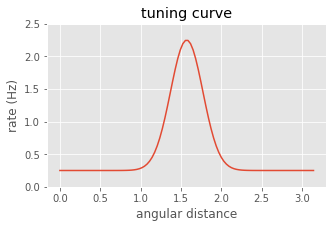

In [5]:
%matplotlib inline
theta_preferred = math.pi/2
R_preferred = 2
C = 0.25
sigma = 0.2

# example orientation-tuning with pi/2 as the preferred orientation
x = np.linspace(0, math.pi, 100)
tc = [tuning_curve(theta_preferred, C, R_preferred, sigma, t) for t in x]

fig, ax = plt.subplots(figsize = (5,3))
ax.plot(x, tc)

ax.set_title("tuning curve")
ax.set_ylabel("rate (Hz)")
ax.set_xlabel("angular distance")
ax.set_ylim((0, 2.5))
plt.show()

In [6]:
# generate orientation-sensitive neurons
n_neurons = 64

# orientations
neuron_orientations = np.random.uniform(low=0, high=math.pi, size=n_neurons)

# R_preferred
R_preferred = [2] * n_neurons

# sigma
sigma = [0.2] * n_neurons

# baseline rate
C = [0.25] * n_neurons


## 3. Get firing rates

Firing rates of training data

In [7]:
# get orientation-sensitive neurons firing rate for training data
y_train = compute_firing_rates(train_orient, neuron_orientations, C, R_preferred, sigma)

# compute firing rates per timebin (per 1/25 seconds)
n_bins = 25
y_train = np.repeat(y_train, n_bins, axis = 0)
print(y_train.shape)

(1000000, 64)


Firing rates of simulation (test) data

In [8]:
# get orientation-sensitive neurons firing rate for simulation data
y_test = compute_firing_rates(sample_orient, neuron_orientations, C, R_preferred, sigma)

# firing rates per timebin (per 1/25 seconds)
y_test = np.repeat(y_test, n_bins, axis = 0)


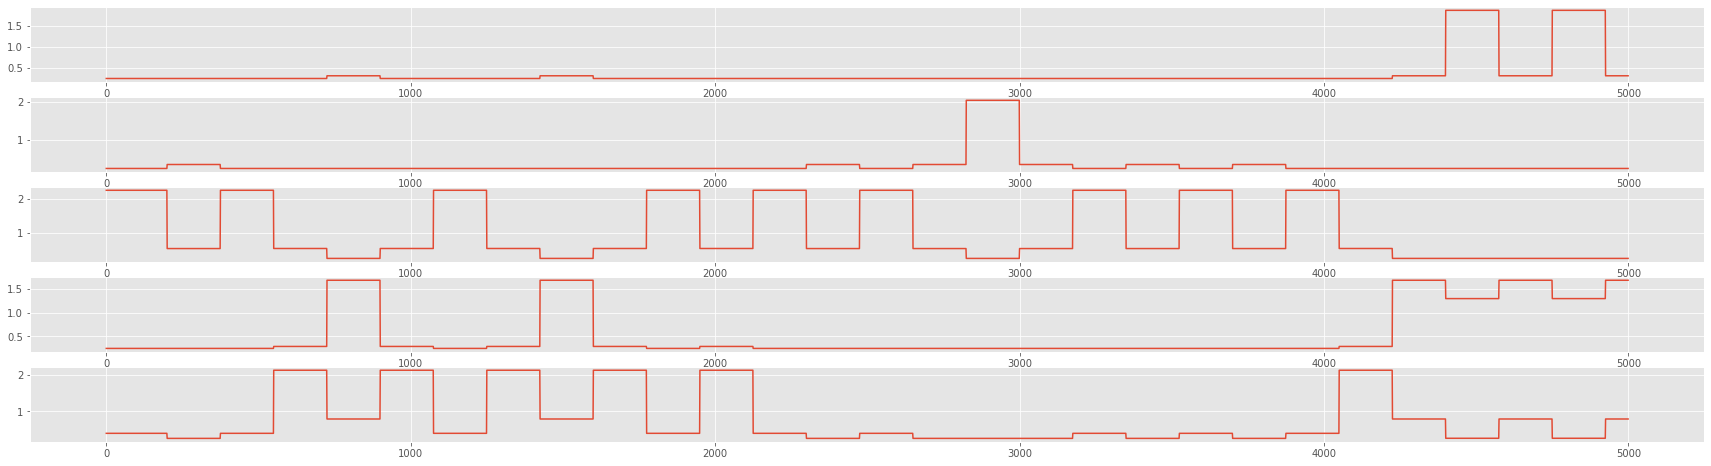

In [9]:
# plot example firing rates
fig, ax = plt.subplots(nrows = 5, figsize = (30, 8))
for i in range(5):
    ax[i].plot(y_train[:5000, i])

plt.show()

## 4. Approximate `f_orientation` via neural networks


In [21]:
# scale target variable -- this turned out to be an important step
scaler = MinMaxScaler()
scaler.fit(y_train)
y_transformed = scaler.transform(y_train)

In [22]:
# Build neural network
model = Sequential()
model.add(Dense(128,  activation = 'relu',  kernel_initializer = "he_normal"))
model.add(Dense(y_train.shape[1], activation = 'relu',  kernel_initializer = "he_normal"))

# compile
model.compile(loss='mean_squared_error', optimizer='Adam')

From training multiple versions of these matrices, it seems like a training & validation loss of 0.07 ~ 0.08 is good.

In [23]:
# callbacks
es = EarlyStopping(monitor='val_loss', patience=3)
checkpoint = ModelCheckpoint(
    filepath='downstream_training/orientation_checkpoint',
    save_weights_only=True,
    monitor='val_loss',
    mode='max',
    save_best_only=True)

# Fit
history = model.fit(x = X_train, y = y_transformed, validation_split = 0.2, callbacks = [es, checkpoint], epochs = 10)


Epoch 1/10
25000/25000 [==============================] - 52s 2ms/step - loss: 0.0544 - val_loss: 0.0492
Epoch 2/10
25000/25000 [==============================] - 50s 2ms/step - loss: 0.0467 - val_loss: 0.0473
Epoch 3/10
25000/25000 [==============================] - 49s 2ms/step - loss: 0.0453 - val_loss: 0.0470
Epoch 4/10
25000/25000 [==============================] - 49s 2ms/step - loss: 0.0445 - val_loss: 0.0468
Epoch 5/10
25000/25000 [==============================] - 49s 2ms/step - loss: 0.0440 - val_loss: 0.0464
Epoch 6/10
25000/25000 [==============================] - 49s 2ms/step - loss: 0.0436 - val_loss: 0.0462
Epoch 7/10
25000/25000 [==============================] - 49s 2ms/step - loss: 0.0433 - val_loss: 0.0471
Epoch 8/10
25000/25000 [==============================] - 49s 2ms/step - loss: 0.0431 - val_loss: 0.0468
Epoch 9/10
25000/25000 [==============================] - 49s 2ms/step - loss: 0.0430 - val_loss: 0.0469


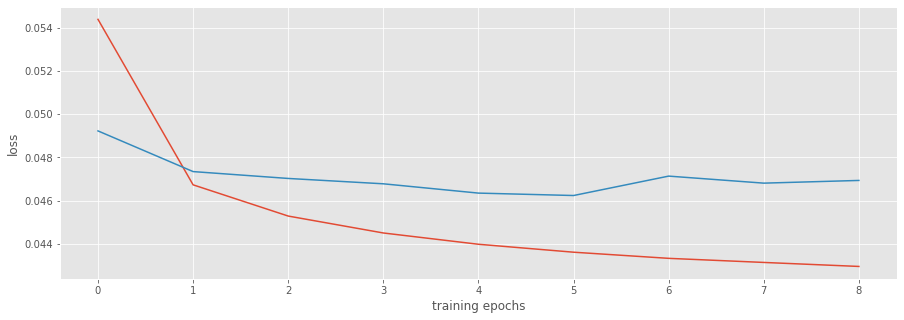

In [24]:
# plot the training and validation loss to determine if overfitting / underfitting 

# get metrics
train_loss = history.history['loss']
val_loss = history.history['val_loss']

n_epochs = len(train_loss)

fig, ax = plt.subplots(figsize = (15,5))
ax.plot(list(range(n_epochs)), train_loss, label ='train loss')
ax.plot(list(range(n_epochs)), val_loss, label ='val loss')
ax.set_xlabel('training epochs')
ax.set_ylabel('loss')

plt.show()

In [31]:
# save model
#model.save(directory + '/orientation_model.h5')  

# save scaler
#joblib.dump(scaler, directory + "/orientation_scaler.save")

['data_downstream_v2/orientation_scaler.save']

## 5. Predict firing rates of orientation-sensitive neurons on simulation set

In [32]:
# load saved model
model = load_model(directory + '/orientation_model.h5')

# load saved scaler
scaler = joblib.load(directory + "/orientation_scaler.save")

Predict firing rates

In [33]:
y_pred, score = predict_rates(X_simulation, y_test, model, scaler)

print("Scores on test (simulation) sets ")
print("score on y_test: ", score)

Scores on test (simulation) sets 
score on y_test:  0.04646806112159729


Plot example predicted rates

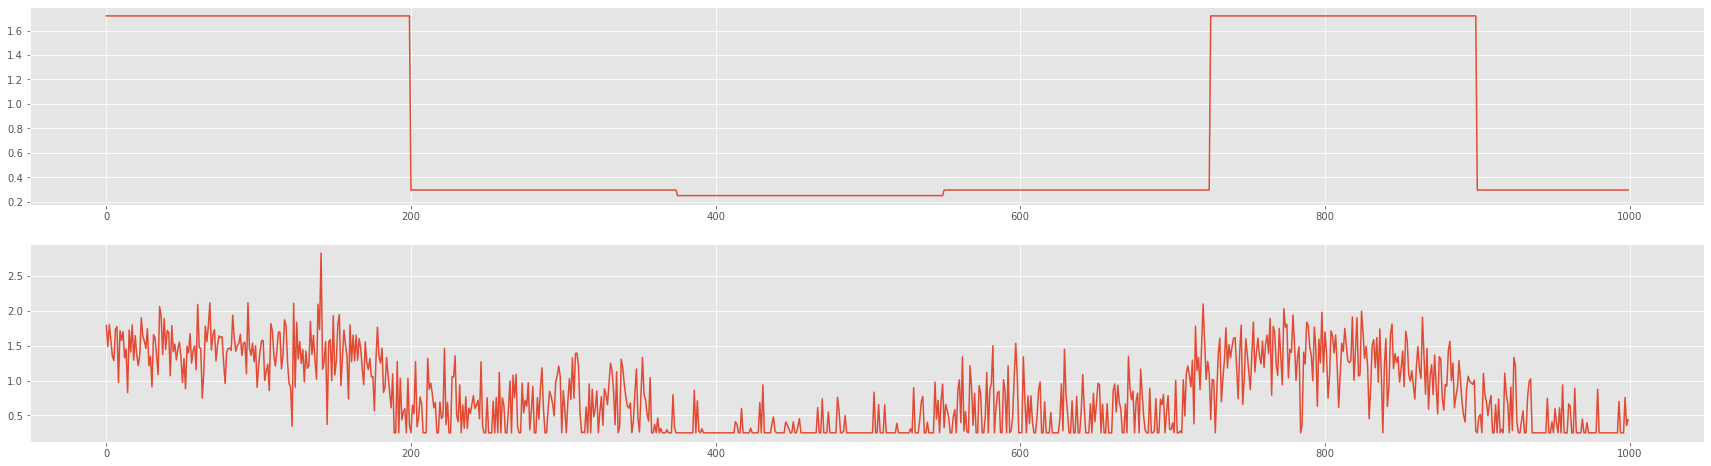

In [34]:
# plot examples of true firing rates and predicted firing rates
neuron = 0
fig, ax = plt.subplots(nrows = 2, figsize = (30, 8))
ax[0].plot(y_test[:1000, neuron])
ax[1].plot(y_pred[:1000, neuron])
plt.show()

## 6. Add noise to firing rates

We add noise to the firing rates by 
* Adding unreliable intervals of firing rates
    * For a fixed orientation-sensitive neuron, the neuron may not always fire at its maximum firing rate every time the same stimulus is presented. We re-created a situation in which a given neuron might fire at its predicted rate or at its baseline firing rate in response to the same stimuli. 
    
    
* Adding Gaussian noise $r(\theta) = [f(\theta) + \eta]_+$
    * $f(\theta)$ : predicted firing rate
    * $\eta$: Gaussian noise
    * $[ \quad ]_+$: rectification of negative values to zero

<b> Add unreliability </b>

In [83]:
y_new = add_unreliable_intervals(y_pred, 0.8, n_bins, 0.25 )

<b> Add noise</b>

Note that the rates are given in Hz. For example, 4Hz means 4 spikes per second. In our raster, 25 timebins correspond to 1 second. So we should divide the rates by 25.

In [84]:
# compute rates from the true lables 
rates = add_noise(y_new/25, 0.05)

Plot noisy rates

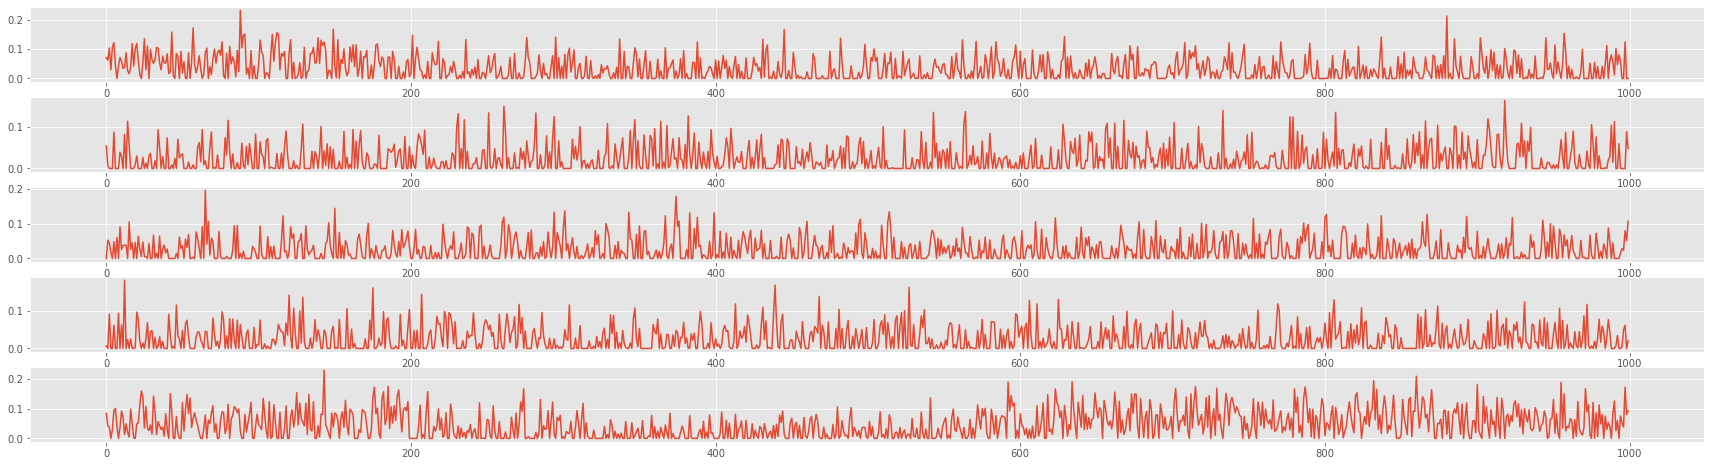

In [85]:
# select neuron #with noise
neuron = 0

fig, ax = plt.subplots(nrows = 5, figsize = (30, 8))
for i in range(5):
    ax[i].plot(rates[:1000, i])

plt.show()

## 6. Simulate raster

Simulate spike trains.


In [86]:
bin_size = 1
raster, _ = simulate_raster(rates, bin_size)

Plot example spike trains

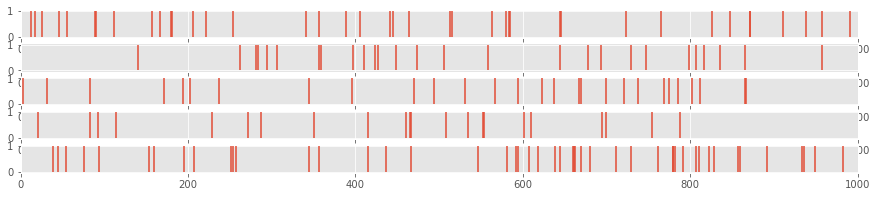

In [87]:
neuron = 0  
start = 0
end = 1000


# plot orientation neuron spike trains
fig, ax = plt.subplots(nrows = 5, figsize = (15, 3))
for i in range(5):
    plot_spike_train(raster[i,:], start, end, ax = ax[i])

plt.show()

Save raster

In [88]:
# save orientation raster

hf = h5py.File(directory + '/orientation_raster.h5', 'w')
hf.create_dataset('raster', data = raster)
hf.close()
